#### If already not installed run this

In [1]:
#!pip install pyspark


### Creating a spark session

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("ProstateCancerBatchAnalytics")
    .config("spark.hadoop.security.authentication", "simple")
    .config("spark.hadoop.security.authorization", "false")
    .config("spark.sql.warehouse.dir", "file:///C:/spark-warehouse")
    .getOrCreate()
)

spark


### Loading the Kaggle dataset into spark

In [3]:
df = spark.read.csv(
    "../data/prostate_cancer_prediction.csv",
    header=True,
    inferSchema=True
)

df.printSchema()
df.show(5)


root
 |-- Patient_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Family_History: string (nullable = true)
 |-- Race_African_Ancestry: string (nullable = true)
 |-- PSA_Level: double (nullable = true)
 |-- DRE_Result: string (nullable = true)
 |-- Biopsy_Result: string (nullable = true)
 |-- Difficulty_Urinating: string (nullable = true)
 |-- Weak_Urine_Flow: string (nullable = true)
 |-- Blood_in_Urine: string (nullable = true)
 |-- Pelvic_Pain: string (nullable = true)
 |-- Back_Pain: string (nullable = true)
 |-- Erectile_Dysfunction: string (nullable = true)
 |-- Cancer_Stage: string (nullable = true)
 |-- Treatment_Recommended: string (nullable = true)
 |-- Survival_5_Years: string (nullable = true)
 |-- Exercise_Regularly: string (nullable = true)
 |-- Healthy_Diet: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking_History: string (nullable = true)
 |-- Alcohol_Consumption: string (nullable = true)
 |-- Hypertension: string (nullable 

## Batch Analytics: PSA Levels by Cancer Stage

This section applies batch processing using Apache Spark to extract population-level
insights from the prostate cancer dataset. Specifically, the average PSA level is
computed for each cancer stage to explore how prostate cancer severity correlates
with PSA measurements.

This analysis establishes a baseline insight that is later compared with the
velocity-oriented processing to observe how these trends evolve as new data arrives.


In [4]:
from pyspark.sql.functions import avg
psa_by_stage = (
    df.groupBy("Cancer_Stage")
      .agg(avg("PSA_Level").alias("avg_psa"))
      .orderBy("Cancer_Stage")
)

psa_by_stage.show()


+------------+-----------------+
|Cancer_Stage|          avg_psa|
+------------+-----------------+
|    Advanced|7.632337405677335|
|   Localized|7.775786365256394|
|  Metastatic|7.820536888239588|
+------------+-----------------+



In [5]:
psa_pd = psa_by_stage.toPandas()
psa_pd


,Cancer_Stage,avg_psa
0,Advanced,7.632337
1,Localized,7.775786
2,Metastatic,7.820537


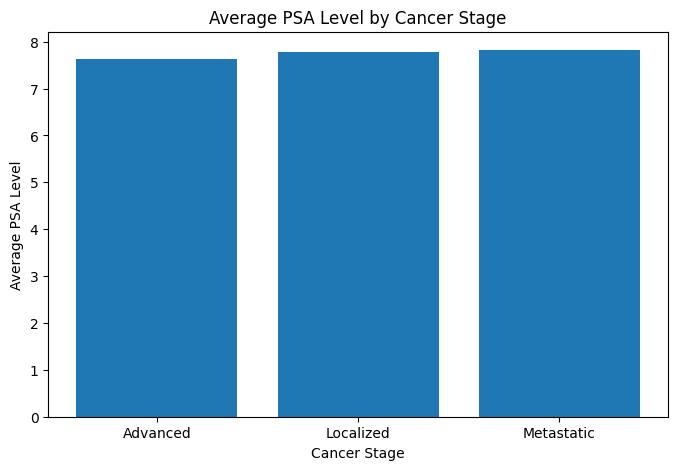

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(psa_pd["Cancer_Stage"], psa_pd["avg_psa"])
plt.xlabel("Cancer Stage")
plt.ylabel("Average PSA Level")
plt.title("Average PSA Level by Cancer Stage")
plt.show()


### Interpretation

The batch analysis indicates a gradual increase in average PSA levels across cancer
stages, with metastatic cases exhibiting the highest mean PSA values. While the
differences between stages are relatively small, this trend aligns with the expectation
that PSA levels tend to rise with disease severity.

These results establish a baseline population-level insight, which is later used as a
reference point for the velocity-oriented analysis to examine how such trends evolve
as new patient data arrives incrementally.


## Batch Analytics: 5-Year Survival Outcomes by Cancer Stage
This batch analytics task focuses on evaluating **long-term patient outcomes** by examining
5-year survival rates across different prostate cancer stages. Survival at five years is a
commonly used clinical benchmark for assessing prognosis and treatment effectiveness in
oncology.

Using Apache Spark, the dataset is grouped by cancer stage and survival outcome, allowing
for efficient aggregation over a large number of patient records. The resulting analysis
highlights how survival outcomes are distributed within each stage, rather than focusing
only on averages.

The results reveal a clear relationship between cancer stage and survival. Patients diagnosed
at the **Localized** stage show the highest number of 5-year survivors, reflecting the
effectiveness of early detection and timely intervention. As the disease progresses to
**Advanced** and **Metastatic** stages, the number and proportion of surviving patients
decrease significantly, indicating poorer prognosis and increased mortality risk.

This analysis demonstrates how batch processing can be used to extract **clinically relevant
outcome-based insights** from large-scale health datasets. When combined with biomarker
analysis such as PSA levels, survival analytics provides a more complete understanding of
disease severity and progression, supporting data-driven reasoning in healthcare analytics.


In [8]:
from pyspark.sql.functions import count



df_survival = df.select(
    "Cancer_Stage",
    "Survival_5_Years"
)

survival_counts = (
    df_survival
    .groupBy("Cancer_Stage", "Survival_5_Years")
    .agg(count("*").alias("count"))
)

survival_counts.show()

survival_pd = survival_counts.toPandas()

pivot_survival = survival_pd.pivot(
    index="Cancer_Stage",
    columns="Survival_5_Years",
    values="count"
).fillna(0)

pivot_survival



+------------+----------------+-----+
|Cancer_Stage|Survival_5_Years|count|
+------------+----------------+-----+
|  Metastatic|              No|  297|
|    Advanced|              No|  522|
|    Advanced|             Yes| 5044|
|   Localized|              No| 1926|
|   Localized|             Yes|17715|
|  Metastatic|             Yes| 2441|
+------------+----------------+-----+



Survival_5_Years,No,Yes
Cancer_Stage,,
Advanced,522,5044
Localized,1926,17715
Metastatic,297,2441


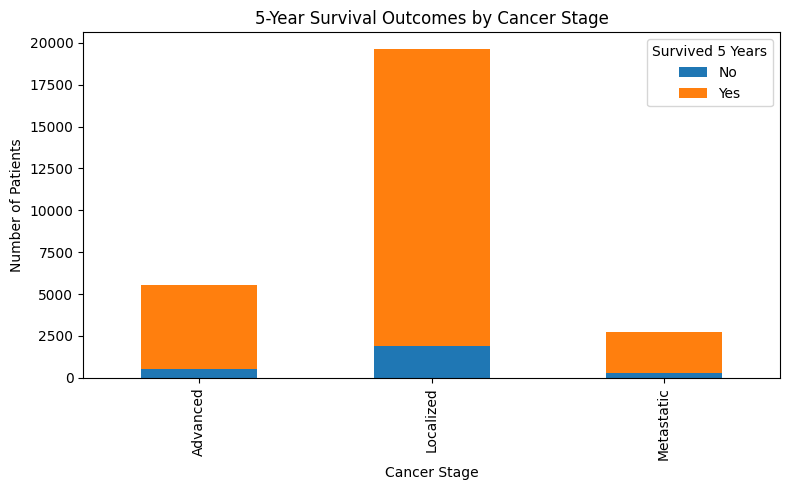

In [9]:
import matplotlib.pyplot as plt

pivot_survival.plot(
    kind="bar",
    stacked=True,
    figsize=(8,5)
)

plt.xlabel("Cancer Stage")
plt.ylabel("Number of Patients")
plt.title("5-Year Survival Outcomes by Cancer Stage")
plt.legend(title="Survived 5 Years")
plt.tight_layout()
plt.show()


### Interpretation: 5-Year Survival Outcomes by Cancer Stage

This stacked bar chart illustrates the distribution of 5-year survival outcomes across
different prostate cancer stages.

Patients diagnosed at the **Localized** stage represent the largest group in the dataset
and show a **substantially higher number of survivors** compared to non-survivors. This
reflects the generally favorable prognosis when prostate cancer is detected early and
managed before spreading beyond the prostate.

In contrast, **Advanced** and especially **Metastatic** cases exhibit noticeably fewer
patients overall and a **higher proportion of non-survivors**, highlighting the increased
mortality risk associated with disease progression. Metastatic cases show the smallest
survivor group, which is consistent with clinical expectations for late-stage cancer.

Overall, this visualization reinforces the importance of **early detection and screening**,
demonstrating how cancer stage at diagnosis strongly influences long-term survival outcomes.
